In [19]:
import pandas as pd
import numpy as np
import pm4py
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [20]:
# Import the data
bpi_data = pd.read_csv("BPI_Challenge_2017.csv", sep=',', quotechar='"')
bpi_data.columns = bpi_data.columns.str.strip()
bpi_data['time'] = pd.to_datetime(bpi_data['time'], format='%Y/%m/%d %H:%M:%S.%f')
bpi_log = pm4py.format_dataframe(bpi_data, case_id='case', activity_key='event', timestamp_key='time')

In [21]:
# Filter in only the events that have lifecycle:transition 'Complete'
bpi_log = bpi_log[bpi_log['lifecycle:transition'] == 'COMPLETE']

# Sort cases by their end times
trace_end_times = bpi_log.groupby('case')['time'].max().reset_index(name='end_time')
trace_start_times = bpi_log.groupby('case')['time'].min().reset_index(name='start_time')
trace_times = trace_end_times.merge(trace_start_times, on="case")
trace_times_sorted = trace_times.sort_values(by='end_time')

# Split training and validation cases
train_size = int(len(trace_times_sorted) * 0.7)
val_size = int(len(trace_times_sorted) * 0.15)

train_cases = trace_times_sorted.iloc[:train_size]['case'].values
val_cases = trace_times_sorted.iloc[train_size:train_size + val_size]['case'].values

# Find the latest end time in training and validation
latest_train_val_end_time = trace_times_sorted.iloc[train_size + val_size - 1]['end_time']

# Filter test cases to ensure no overlap
test_cases = trace_times_sorted[
    trace_times_sorted['start_time'] > latest_train_val_end_time
]['case'].values

# Filter the log for each set
train_log = bpi_log[bpi_log['case'].isin(train_cases)]
val_log = bpi_log[bpi_log['case'].isin(val_cases)]
test_log = bpi_log[bpi_log['case'].isin(test_cases)]

print("Training Set End Time:", train_log['time'].max())
print("Validation Set End Time:", val_log['time'].max())
print("Test Set Start Time:", test_log['time'].min())

total_cases = len(trace_times_sorted)
print(f"Training Set: {len(train_cases) / total_cases * 100:.2f}%")
print(f"Validation Set: {len(val_cases) / total_cases * 100:.2f}%")
print(f"Test Set: {len(test_cases) / total_cases * 100:.2f}%")

train_log

Training Set End Time: 2016-10-10 08:00:35.779000+00:00
Validation Set End Time: 2016-11-25 08:00:18.278000+00:00
Test Set Start Time: 2016-11-25 08:20:16.638000+00:00
Training Set: 70.00%
Validation Set: 15.00%
Test Set: 9.12%


,case,event,time,lifecycle:transition,ApplicationType,LoanGoal,RequestedAmount,MonthlyCost,org:resource,Selected,...,Accepted,CreditScore,NumberOfTerms,EventOrigin,OfferedAmount,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,Application_1000086665,A_Create Application,2016-08-03 17:57:21.673000+00:00,COMPLETE,New credit,"Other, see explanation",5000.0,NaN,User_1,NaN,...,NaN,NaN,NaN,Application,NaN,Application_1000086665,A_Create Application,2016-08-03 17:57:21.673000+00:00,0,0
1,Application_1000086665,A_Submitted,2016-08-03 17:57:21.734000+00:00,COMPLETE,New credit,"Other, see explanation",5000.0,NaN,User_1,NaN,...,NaN,NaN,NaN,Application,NaN,Application_1000086665,A_Submitted,2016-08-03 17:57:21.734000+00:00,1,0
5,Application_1000086665,A_Concept,2016-08-03 17:58:28.299000+00:00,COMPLETE,New credit,"Other, see explanation",5000.0,NaN,User_1,NaN,...,NaN,NaN,NaN,Application,NaN,Application_1000086665,A_Concept,2016-08-03 17:58:28.299000+00:00,5,0
8,Application_1000086665,A_Accepted,2016-08-05 15:57:07.419000+00:00,COMPLETE,New credit,"Other, see explanation",5000.0,NaN,User_5,NaN,...,NaN,NaN,NaN,Application,NaN,Application_1000086665,A_Accepted,2016-08-05 15:57:07.419000+00:00,8,0
9,Application_1000086665,O_Create Offer,2016-08-05 15:59:57.320000+00:00,COMPLETE,New credit,"Other, see explanation",5000.0,241.28,User_5,False,...,True,0.0,22.0,Offer,5000.0,Application_1000086665,O_Create Offer,2016-08-05 15:59:57.320000+00:00,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202219,Application_999993467,O_Returned,2016-07-13 16:30:00.134000+00:00,COMPLETE,Limit raise,Home improvement,10000.0,NaN,User_116,NaN,...,NaN,NaN,NaN,Offer,NaN,Application_999993467,O_Returned,2016-07-13 16:30:00.134000+00:00,1202219,31507
1202228,Application_999993467,O_Accepted,2016-07-19 13:03:45.111000+00:00,COMPLETE,Limit raise,Home improvement,10000.0,NaN,User_30,NaN,...,NaN,NaN,NaN,Offer,NaN,Application_999993467,O_Accepted,2016-07-19 13:03:45.111000+00:00,1202228,31507
1202229,Application_999993467,A_Pending,2016-07-19 13:03:45.115000+00:00,COMPLETE,Limit raise,Home improvement,10000.0,NaN,User_30,NaN,...,NaN,NaN,NaN,Application,NaN,Application_999993467,A_Pending,2016-07-19 13:03:45.115000+00:00,1202229,31507
1202230,Application_999993467,W_Validate application,2016-07-19 13:03:45.120000+00:00,COMPLETE,Limit raise,Home improvement,10000.0,NaN,User_30,NaN,...,NaN,NaN,NaN,Workflow,NaN,Application_999993467,W_Validate application,2016-07-19 13:03:45.120000+00:00,1202230,31507


In [22]:
def get_labels(log):
    """
    Generates binary labels for cases in the log.
    Label is 1 if event "A_Pending" occurs in the case, 0 otherwise.
    
    Parameters:
    log (pd.DataFrame): The event log dataframe.
    
    Returns:
    pd.Series: A series with case IDs as index and binary labels as values.
    """
    # Group by case and check if "A_Pending" event exists in each case
    labels = log.groupby('case')['event'].apply(lambda events: 1 if 'A_Pending' in events.values else 0)
    return labels

train_log_labels = get_labels(train_log)
val_log_labels = get_labels(val_log)
test_log_labels = get_labels(test_log)

train_log_labels

case
Application_1000086665    0
Application_1000158214    1
Application_1000311556    0
Application_1000334415    0
Application_1000339879    1
                         ..
Application_99940018      1
Application_999487618     1
Application_999507989     1
Application_999544538     1
Application_999993467     1
Name: event, Length: 22056, dtype: int64

In [23]:
def get_credit_scores(log):
    """
    Extracts the credit scores for each case in the log.
    
    Parameters:
    log (pd.DataFrame): The event log dataframe.
    
    Returns:
    pd.Series: A series with case IDs as index and credit scores as values.
    """
    # Group by case and get the first non-null credit score for each case
    credit_scores = log.groupby('case')['CreditScore'].first()
    return credit_scores

train_credit_scores = get_credit_scores(train_log)
val_credit_scores = get_credit_scores(val_log)
test_credit_scores = get_credit_scores(test_log)

In [24]:
def get_event_frequency_encoding(log, decision_event):
    """
    Filters the log to include only events occurring before the decision event in each case,
    and generates frequency encoding of events for each case.

    Parameters:
    log (pd.DataFrame): The event log dataframe.
    decision_event (str): The event name that marks the decision point.

    Returns:
    pd.DataFrame: A dataframe with case IDs as index and frequency encoding of events as columns.
    """
    def filter_case_events(case_events):
        if decision_event in case_events['event'].values:
            decision_index = case_events[case_events['event'] == decision_event].index[0]
            return case_events.loc[:decision_index - 1]
        return case_events

    # Filter events before the decision point
    filtered_log = log.groupby('case').apply(filter_case_events).reset_index(drop=True)

    # Create a pivot table with cases as rows and events as columns, counting occurrences
    event_frequency = filtered_log.pivot_table(index='case', columns='event', aggfunc='size', fill_value=0)

    return event_frequency

decision_event = "A_Complete"
train_event_frequency = get_event_frequency_encoding(train_log, decision_event)
val_event_frequency = get_event_frequency_encoding(val_log, decision_event)
test_event_frequency = get_event_frequency_encoding(test_log, decision_event)

train_event_frequency.head()

C:\Users\cshek\AppData\Local\Temp\ipykernel_21192\2406770448.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_log = log.groupby('case').apply(filter_case_events).reset_index(drop=True)
C:\Users\cshek\AppData\Local\Temp\ipykernel_21192\2406770448.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_log = log.groupby('case').apply(filter_case_events).reset_index(drop=True)
C:\Users\cshek

event,A_Accepted,A_Cancelled,A_Concept,A_Create Application,A_Denied,A_Submitted,O_Cancelled,O_Create Offer,O_Created,O_Refused,O_Sent (mail and online),O_Sent (online only),W_Assess potential fraud,W_Complete application,W_Handle leads
case,,,,,,,,,,,,,,,
Application_1000086665,1,0,1,1,0,1,0,1,1,0,1,0,0,0,0
Application_1000158214,1,0,1,1,0,1,0,1,1,0,1,0,0,1,0
Application_1000311556,1,0,1,1,0,0,0,1,1,0,1,0,0,1,0
Application_1000334415,1,0,1,1,0,1,0,1,1,0,1,0,0,1,0
Application_1000339879,1,0,1,1,0,1,0,1,1,0,1,0,0,1,0


In [25]:
def get_time_difference_to_complete(log, decision_event):
    """
    Calculates the time difference between the first event in the case and the time when the decision event occurs.
    
    Parameters:
    log (pd.DataFrame): The event log dataframe.
    decision_event (str): The event name that marks the decision point.
    
    Returns:
    pd.Series: A series with case IDs as index and time differences as values.
    """
    def calculate_time_difference(case_events):
        if decision_event in case_events['event'].values:
            first_event_time = pd.Timestamp(case_events['time'].min())
            decision_event_time = pd.Timestamp(case_events[case_events['event'] == decision_event]['time'].values[0])
            # Ensure both datetime objects are timezone-naive
            first_event_time = first_event_time.tz_localize(None)
            decision_event_time = decision_event_time.tz_localize(None)
            return (decision_event_time - first_event_time).total_seconds()
        return np.nan
    
    time_differences = log.groupby('case').apply(calculate_time_difference)
    return time_differences

train_time_diff = get_time_difference_to_complete(train_log, decision_event)
val_time_diff = get_time_difference_to_complete(val_log, decision_event)
test_time_diff = get_time_difference_to_complete(test_log, decision_event)

# Set the name of the Series
train_time_diff.name = 'time_diff'
val_time_diff.name = 'time_diff'
test_time_diff.name = 'time_diff'

train_credit_scores.name = 'credit_score'
val_credit_scores.name = 'credit_score'
test_credit_scores.name = 'credit_score'

C:\Users\cshek\AppData\Local\Temp\ipykernel_21192\1299692016.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_differences = log.groupby('case').apply(calculate_time_difference)
C:\Users\cshek\AppData\Local\Temp\ipykernel_21192\1299692016.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_differences = log.groupby('case').apply(calculate_time_difference)
C:\Users\cshek\AppData\Local\Temp\ipyk

In [26]:
def get_loan_goal_encoding(log, encoder=None):
    """
    Extracts and encodes the LoanGoal for each case in the log.
    
    Parameters:
    log (pd.DataFrame): The event log dataframe.
    encoder (OneHotEncoder, optional): The OneHotEncoder instance to use for encoding.
    
    Returns:
    pd.DataFrame: A dataframe with case IDs as index and one-hot encoded LoanGoal as columns.
    OneHotEncoder: The OneHotEncoder instance used for encoding.
    """
    # Group by case and get the first non-null LoanGoal for each case
    loan_goals = log.groupby('case')['LoanGoal'].first().reset_index()
    
    # One-hot encode the LoanGoal
    if encoder is None:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        loan_goal_encoded = encoder.fit_transform(loan_goals[['LoanGoal']])
    else:
        loan_goal_encoded = encoder.transform(loan_goals[['LoanGoal']])
    
    # Create a DataFrame with the encoded LoanGoal
    loan_goal_encoded_df = pd.DataFrame(loan_goal_encoded, columns=encoder.get_feature_names_out(['LoanGoal']))
    loan_goal_encoded_df['case'] = loan_goals['case']
    
    # Set the case as the index
    loan_goal_encoded_df.set_index('case', inplace=True)
    
    return loan_goal_encoded_df, encoder

train_loan_goal_encoded, encoder = get_loan_goal_encoding(train_log)
val_loan_goal_encoded, _ = get_loan_goal_encoding(val_log, encoder)
test_loan_goal_encoded, _ = get_loan_goal_encoding(test_log, encoder)

Validation Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.83      2110
           1       0.94      0.75      0.83      2616

    accuracy                           0.83      4726
   macro avg       0.84      0.84      0.83      4726
weighted avg       0.85      0.83      0.83      4726



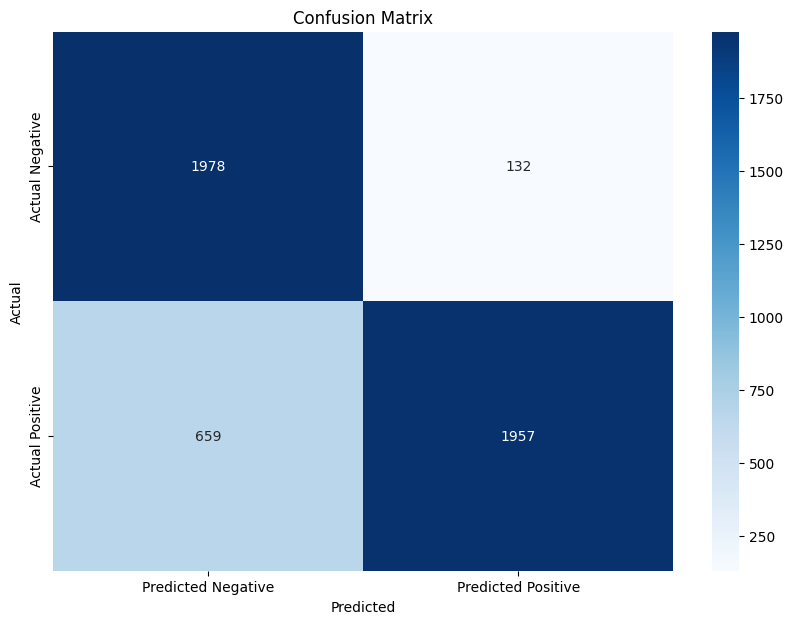

In [27]:
# Prepare the features and the labels
y_train = train_log_labels
y_val = val_log_labels

# Combine the event frequency encoding, credit scores, time differences, and loan goal encoding
X_train = train_event_frequency.join(train_credit_scores, on='case').join(train_time_diff, on='case').join(train_loan_goal_encoded, on='case')
X_val = val_event_frequency.join(val_credit_scores, on='case').join(val_time_diff, on='case').join(val_loan_goal_encoded, on='case')

# Fill any missing values with -1
X_train.fillna(-1, inplace=True)
X_val.fillna(-1, inplace=True)

# Apply SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the Random Forest model
rf_classifier = RandomForestClassifier(
    n_estimators=1000, min_samples_split=5, 
        min_samples_leaf=10, random_state=42, 
        oob_score=True, class_weight="balanced",
        max_features="sqrt",
        max_depth=20)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred = rf_classifier.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Extract feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df.sort_values(by='importance', ascending=False).to_csv('feature_importances.csv', index=False)

In [31]:
# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 500, 1000),  # Randomly sample between 100 and 1000 trees
    'max_depth': [10, 20, 30, None],  # Different tree depths
    'min_samples_split': randint(2, 10),  # Minimum samples to split
    'min_samples_leaf': randint(1, 10),  # Minimum samples in leaf nodes
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
    'class_weight': ['balanced', None]  # Handle class imbalance
}

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, oob_score=True)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_distributions,
    n_iter=2,  
    scoring='f1_macro', 
    cv=2,  
    verbose=2,
    random_state=42,
    n_jobs=-1 
)   

# Fit the RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and corresponding score
print("Best Parameters:", random_search.best_params_)
print("Best F1 Macro Score:", random_search.best_score_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


KeyboardInterrupt: 

In [ ]:
# Prepare the features and the labels
y_test = test_log_labels
X_test = test_event_frequency.join(test_credit_scores, on='case').join(test_time_diff, on='case').join(test_loan_goal_encoded, on='case')

# Fill any missing values with -1
X_test.fillna(-1, inplace=True)

# Predict on the test set
y_test_pred = rf_classifier.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.2f}")
print("Classification Report:\n", test_report)

# Plot Confusion Matrix for test set
plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()